In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd


%matplotlib inline

# Porosity and Saturation affects on AVO

### Gassmann Relation

A basic, blocked log implementation of Gassmann fluid substitution to help explore the affects of different fluids on the seismic response.

$$\frac{1}{K_{rock}}\ =\ \frac{1}{K_{mineral}}\ +\ \frac{\phi}{K_{\phi} + K_{fluid}}$$

$K_{rock} = \text{Bulk modulus of the whole rock, including pore-filling fluids}$  
$K_{mineral} = \text{Bulk modulus of the mineral constituent}$  
$K_{phi} = \text{Pore stiffness}$  
$K_{fluid} = \text{Bulk modulus of the fluid}$ 

#### Gassmann fluid substitution recipe from Avseth, 2006$^{[1]}$

$\textbf{Step 1:}$ Extract the dynamic bulk and shear moduli from $V_{p}^{(1)}$, $V_{s}^{(1)}$ , and $\rho^{(1)}$:

$K^{(1)}\ =\ \rho((V_{p}^{(1)})^2 - \frac{4}{3}(V_{s}^{(1)})^2)\\ \mu^{(1)}\ =\ \rho(V_{s}^{(1)})^2$

$\textbf{Step 2:}$ Apply Hassmann's relation to transform the bulk modulus:

$\frac{K_{sat}^{(2)}}{K_{mineral}\ -\ K_{sat}^{(2)}}\ -\ \frac{K_{fluid}^{(2)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(2)})}\ =\ \frac{K_{sat}^{(1)}}{K_{mineral}\ -\ K_{sat}^{(1)}}\ -\ \frac{K_{fluid}^{(1)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(1)})}$

$\textbf{Step 3:}$ Leave the shear modulus unchanged:

$\mu_{sat}^{(1)} = \mu_{sat}^{(2)}$

$\textbf{Step 4:}$ Remember to correct the bulk density for the fluid change:

$\rho^{(2)} = \rho^{(1)} + \phi(\rho_{fluid}^{(2)} - \rho_{fluid}^{(1)})$

$\textbf{Step 5:}$ Reassemble the velocities:

$V_p^{(2)} = \sqrt{\frac{K_{sat}^{(2)} + \frac{4}{3} \mu_{sat}^{(2)}}{\rho^{(2)}}}$

$V_s^{(2)} = \sqrt{\frac{\mu_{sat}^{(2)}}{\rho^{(2)}}}$


$^{[1]}$Avseth, Per; Mukerji, Tapan; Mavko, Gary. Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk (Kindle Locations 582-584). Cambridge University Press. Kindle Edition. 

### Input data

In [2]:
# In situ parameters are GOM clean sand 100% brine saturated values
vpInSitu = 3550 # m/s
vsInSitu = 1900 # m/s
rhobInSitu = 2240 # kg/m^3
rhofl1 = 1056 # kg/m^3 for 88,000 ppm NaCl brine (@ 10,500 psi and 360 K)
phi = np.round((2650 - rhobInSitu)/(2650 - rhofl1),2)

KflBrine = 3.1*1e9 # water GPa
KflOil =  1.9*1e9 # oil GPa
KflGas = 0.23*1e9 # gas GPa
Kmineral = 37.0*1e9 # Gpa Quartz

rhoflOil = 836 # oil kg/m^3 (@ 10,500 psi and 360 K) 35 API
rhoflGas = 295 # dry gas kg/m^3 (@ 10,500 psi and 360 K)

resThickness = 100 # thickness in meters

# encasing rock properties
vpEncase, vsEncase, rhobEncase = 3350,1700,2500

# Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency

#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

# Angle of incidence range
thetaMax = 50

##### Useful functions

In [3]:
def basicFluidSub(vpInSitu,vsInSitu,rhoInSitu,Kmineral,Kfl1,Kfl2,rhofl1,rhofl2):
    
    # From Avseth, 2006 
    # Avseth, Per; Mukerji, Tapan; Mavko, Gary. 
    # Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk
    
    # Step 1: Extract the dynamic bulk and shear moduli from vp, vs, and rhob
    Ksat1 = (rhoInSitu*(vpInSitu**2 - (4/3)*vsInSitu**2)) # put in GPa
    muSat1 = rhoInSitu * vsInSitu**2

    # Step 2: Apply gassma
    sat = Ksat1 / (Kmineral - Ksat1)
    fluid1 = Kfl1 / (phi*(Kmineral - Kfl1))
    fluid2 = Kfl2 / (phi*(Kmineral - Kfl2))
    Ksat2 = Kmineral / ((1/(sat - fluid1 + fluid2)) + 1)
    
    # step 3

    muSat2 = muSat1 # Gassmann formulation shows that the shear modulus is unaffected by fluid changes

    # step 4

    rhob2 = rhoInSitu + phi*(rhofl2 - rhofl1)

    # step 5 
    M = Ksat2 + 4*muSat2 / 3
    vpNew = np.sqrt(M / rhob2)
    vsNew = np.sqrt(muSat2 / rhob2)
    
    return vpNew, vsNew, rhob2

# Full Zoeppritz Rpp and Rps from Aki and Richards 1980 derivation
# Can take an array as input 
def zoeRppRps(vp,vs,rho,thetaMax,RppCalc = True, RpsCalc = True):    
    theta1 = np.radians(np.arange(thetaMax)).astype(complex)
    p = np.sin(theta1) / vp[0]  # Ray parameter
    theta2 = np.arcsin(p * vp[1])
    phi1 = np.arcsin(p * vs[0])  # Reflected S
    phi2 = np.arcsin(p * vs[1])  # Transmitted S

    a = rho[1] * (1 - 2 * np.sin(phi2)**2.) - rho[0] * (1 - 2 * np.sin(phi1)**2.)
    b = rho[1] * (1 - 2 * np.sin(phi2)**2.) + 2 * rho[0] * np.sin(phi1)**2.
    c = rho[0] * (1 - 2 * np.sin(phi1)**2.) + 2 * rho[1] * np.sin(phi2)**2.
    d = 2 * (rho[1] * vs[1]**2 - rho[0] * vs[0]**2)

    E = (b * np.cos(theta1) / vp[0]) + (c * np.cos(theta2) / vp[1])
    F = (b * np.cos(phi1) / vs[0]) + (c * np.cos(phi2) / vs[1])
    G = a - d * np.cos(theta1)/vp[0] * np.cos(phi2)/vs[1]
    H = a - d * np.cos(theta2)/vp[1] * np.cos(phi1)/vs[0]

    D = E*F + G*H*p**2
    
    if RppCalc == True:
        Rpp = (1/D) * (F*(b*(np.cos(theta1)/vp[0]) - c*(np.cos(theta2)/vp[1])) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp[0])*(np.cos(phi2)/vs[1])))
        return np.real(Rpp)
    if RpsCalc == True:
        Rps = (1/(vs[0]*D)) * (-2*(np.cos(theta1)/vp[0]) * (a*b + c*d*((np.cos(theta2)*np.cos(phi2))/(vp[1]*vs[0]))*p*vp[0]))
        return np.real(Rps),p
    

def plot_vawig(axhdl, data, t, excursion, highlight=None):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape

    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        if i==highlight:
            lw = 2
        else:
            lw = 0.5

        axhdl.plot(tbuf, t, color='black', linewidth=lw)

        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)
    
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def calc_rc(vp_mod, rho_mod):
    '''
    rc_int = calc_rc(vp_mod, rho_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1
    
    rc_int = []
    for i in range(0, nint):
        buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
        buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
        buf3 = buf1/buf2
        rc_int.append(buf3)
    
    return rc_int
    

def calc_times(z_int, vp_mod):
    '''
    t_int = calc_times(z_int, vp_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
            t_int.append(tbuf)
    
    return t_int



def digitize_model(rc_int, t_int, t):
    '''
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''   
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc


##### Calculations occur here

In [4]:
lyr_times = []

#nlayers = len(vp_mod)
#nint = nlayers - 1

# Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

# Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

# Calculate fluid substituted velocities

fluidSubs = np.array(['Brine (vp,vs,rhob)', 'Oil (vp,vs,rhob)', 'Gas (vp,vs,rhob)'])
s=[[] for i in np.arange(len(fluidSubs))]
subProps = pd.Series(s,index = fluidSubs)

vp = []
vs = []
rhob = []
rhofl2 = np.array([rhofl1, rhoflOil, rhoflGas])
Kfls = np.array([KflBrine, KflOil, KflGas])

for i in range(0,len(fluidSubs)):
    subProps[i] = basicFluidSub(vpInSitu, vsInSitu, rhobInSitu, Kmineral, KflBrine, Kfls[i], rhofl1, rhofl2[i])
#subProps[0] = (float(vpInSitu), float(vsInSitu), float(rhobInSitu)) # above method messes up in situ params, replace here

RppTop = []
RppBase = []

for i in range(0,len(fluidSubs)):
    vp.append([vpEncase, subProps[i][0],vpEncase])
    vs.append([vsEncase,subProps[i][1],vsEncase])
    rhob.append([rhobEncase,subProps[i][2],rhobEncase])
    
# Calculate reflectivities
RppTop = []
RppBase = []

for i in range(0,len(fluidSubs)):
    RppTop.append([zoeRppRps(vp[i],vs[i], rhob[i], thetaMax, RppCalc = True, RpsCalc = False)])
    RppBase.append([zoeRppRps(vp[i][1:],vs[i][1:],rhob[i][1:], thetaMax, RppCalc = True, RpsCalc = False)])
    
RppBrine = np.array(RppTop[0]).T
RppOil = np.array(RppTop[0]).T
RppGas = np.array(RppTop[0]).T

# Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)

# Calculate interface depths
z_int = [0,500]
z_int.append(z_int[1] + resThickness)

# curve plots in depth
# make lists of three arrays to hold each fluid subbed curve

vpCurve = []
vsCurve = []
rhoCurve = []

for i in range(0,len(vp)):
    vpCurve.append(np.array(np.zeros(z_int[1]*2 + resThickness)))
    vsCurve.append(np.array(np.zeros(z_int[1]*2 + resThickness)))
    rhoCurve.append(np.array(np.zeros(z_int[1]*2 + resThickness)))
# Convert into arrays to make them easier to work with    
vpCurve = np.array(vpCurve)
vsCurve = np.array(vsCurve)
rhobCurve = np.array(rhoCurve)
    
for i in np.arange(len(z_int)):
    vpCurve[0][z_int[i]:] = vp[0][i] # this is close but not there yet
    vpCurve[1][z_int[i]:] = vp[1][i]
    vpCurve[2][z_int[i]:] = vp[2][i]
    vsCurve[0][z_int[i]:] = vs[0][i]
    vsCurve[1][z_int[i]:] = vs[1][i]
    vsCurve[2][z_int[i]:] = vs[2][i]
    rhobCurve[0][z_int[i]:] = rhob[0][i]
    rhobCurve[1][z_int[i]:] = rhob[1][i]
    rhobCurve[2][z_int[i]:] = rhob[2][i]
                
# Calculate interface times

t_int = calc_times(z_int[i:], vp[0])
lyr_times.append(t_int)

# Digitize 3-layer model
#syn_zoep_pp = []
#for i in range(0,thetaMax):
#    rc = digitize_model(rc_zpp[i], t_int, t)
#    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
#    syn_buf = list(syn_buf)
#    syn_zoep_pp.append(syn_buf)

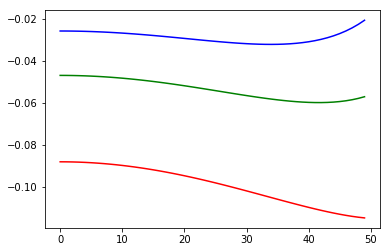

In [17]:
#plt.plot(zoeRppRps(vpInSitu,vsInSitu,rhobInSitu,thetaMax,RppCalc = True, RpsCalc = False),'k')
plt.plot(np.array(RppTop[0]).T,color='b')
plt.plot(np.array(RppTop[1]).T, color='g')
plt.plot(np.array(RppTop[2]).T, color = 'r')
#plt.plot(zoeRppRps(vpInSitu2,vsInSitu2,rhobInSitu2,thetaMax,RppCalc=True,RpsCalc=False),'k')
#plt.plot()

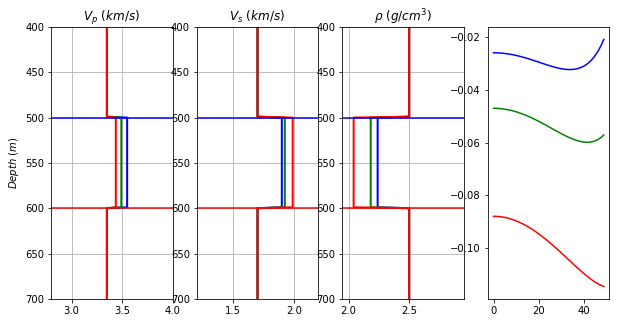

In [27]:
plt.figure(figsize=(10,5))
color = ['b','g','r']

ax1 = plt.subplot(141)
for i in range(0,len(vpCurve)):
    ax1.plot(vpCurve[i]/1000, np.arange(len(vpCurve[0]/1000)), color = color[i],linewidth = 2)
ax1.set_xlim(2.8,4)
ax1.set_ylim(z_int[1]-100,z_int[2]+100)
ax1.set_title(r'$V_p\ (km/s)$')
ax1.set_ylabel(r'$Depth\ (m)$')
ax1.axhline(z_int[1],color = 'b')
ax1.axhline(z_int[2],color = 'r')
ax1.grid()
ax1.invert_yaxis()

ax2 = plt.subplot(142)
for i in range(0,len(vpCurve)):
    ax2.plot(vsCurve[i]/1000, np.arange(len(vsCurve[0]/1000)), color = color[i],linewidth = 2)
ax2.set_xlim(1.2,2.2)
ax2.set_ylim(z_int[1]-100,z_int[2]+100)
ax2.set_title(r'$V_s\ (km/s)$')
ax2.axhline(z_int[1],color = 'b')
ax2.axhline(z_int[2],color = 'r')
ax2.grid()
ax2.invert_yaxis()

ax3 = plt.subplot(143)
for i in range(0,len(vpCurve)):
    ax3.plot(rhobCurve[i]/1000, np.arange(len(vpCurve[0]/1000)), color = color[i],linewidth = 2)
ax3.set_xlim(1.95,2.95)
ax3.set_ylim(z_int[1]-100,z_int[2]+100)
ax3.set_title(r'$\rho \ (g/cm^3)$')
ax3.axhline(z_int[1],color = 'b')
ax3.axhline(z_int[2],color = 'r')
ax3.grid()
ax3.invert_yaxis()

ax4 = plt.subplot(144)
for i in range(0,len(vpCurve)):
    plt.plot(np.array(RppTop[i]).T,color=color[i])



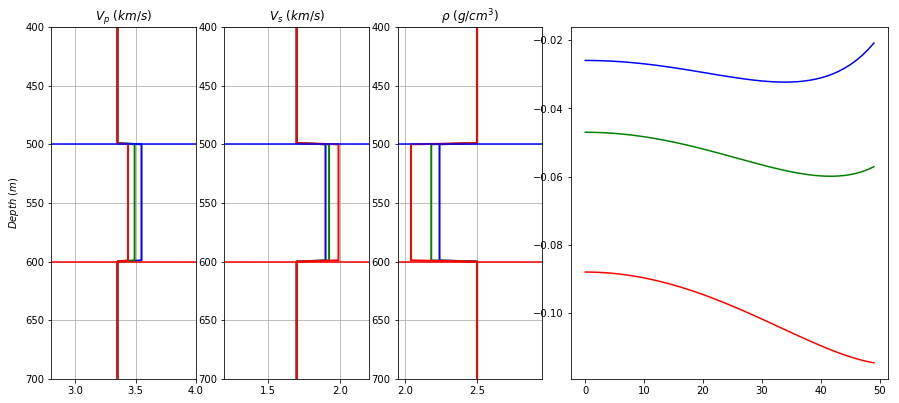

In [87]:
plt.figure(figsize = (15,10))

ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=1, rowspan = 2)
ax2 = plt.subplot2grid((3, 5), (0, 1), colspan = 1, rowspan = 2)
ax3 = plt.subplot2grid((3, 5), (0, 2), colspan = 1, rowspan = 2)
ax4 = plt.subplot2grid((3, 5), (0, 3), colspan = 2, rowspan = 2)

plt.figure(figsize=(10,5))
color = ['b','g','r']

for i in range(0,len(vpCurve)):
    ax1.plot(vpCurve[i]/1000, np.arange(len(vpCurve[0]/1000)), color = color[i],linewidth = 2)
ax1.set_xlim(2.8,4)
ax1.set_ylim(z_int[1]-100,z_int[2]+100)
ax1.set_title(r'$V_p\ (km/s)$')
ax1.set_ylabel(r'$Depth\ (m)$')
ax1.axhline(z_int[1],color = 'b')
ax1.axhline(z_int[2],color = 'r')
ax1.grid()
ax1.invert_yaxis()

for i in range(0,len(vpCurve)):
    ax2.plot(vsCurve[i]/1000, np.arange(len(vsCurve[0]/1000)), color = color[i],linewidth = 2)
ax2.set_xlim(1.2,2.2)
ax2.set_ylim(z_int[1]-100,z_int[2]+100)
ax2.set_title(r'$V_s\ (km/s)$')
ax2.axhline(z_int[1],color = 'b')
ax2.axhline(z_int[2],color = 'r')
ax2.grid()
ax2.invert_yaxis()

for i in range(0,len(vpCurve)):
    ax3.plot(rhobCurve[i]/1000, np.arange(len(vpCurve[0]/1000)), color = color[i],linewidth = 2)
ax3.set_xlim(1.95,2.95)
ax3.set_ylim(z_int[1]-100,z_int[2]+100)
ax3.set_title(r'$\rho \ (g/cm^3)$')
ax3.axhline(z_int[1],color = 'b')
ax3.axhline(z_int[2],color = 'r')
ax3.grid()
ax3.invert_yaxis()

for i in range(0,len(vpCurve)):
    ax4.plot(np.array(RppTop[i]).T,color=color[i])

